In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime, timedelta
import warnings

from sklearn.linear_model import LinearRegression
import yfinance as yf

[*********************100%%**********************]  1 of 1 completed


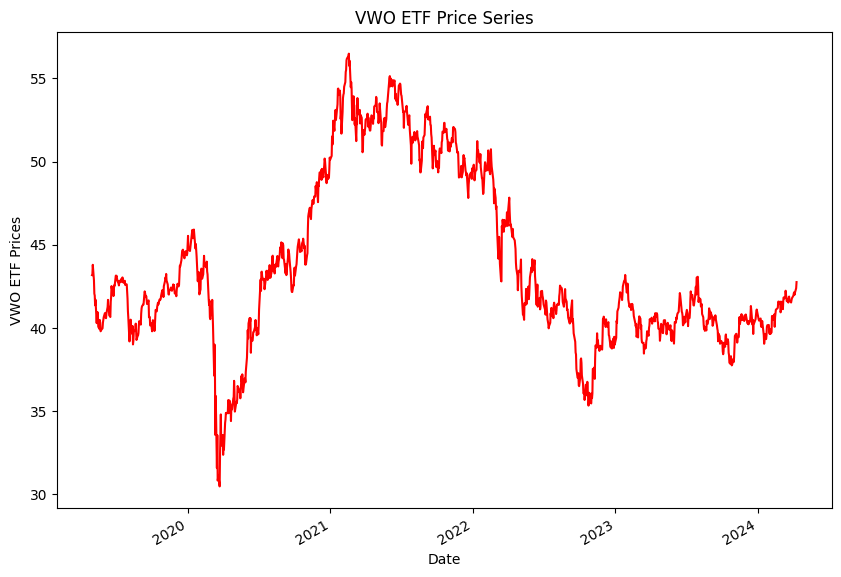

In [2]:
# machine learning linear regression
df = yf.download('VWO', '2019-05-01', '2024-04-10')
df = df[['Close']]

# only keep closing price
df = df.dropna()
df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("VWO ETF Prices")
plt.title("VWO ETF Price Series")
plt.show()

In [3]:
# train: use moving averages over last 3 days and 9 days 
df['S_3'] = df['Close'].rolling(window=3).mean()
df['S_9'] = df['Close'].rolling(window=9).mean()
df['next_day_price'] = df['Close'].shift(-1)

df = df.dropna()
x = df[['S_3', 'S_9']]

y = df['next_day_price']

# separate testing and training data
index = int(0.8*(len(df)))
x_train, x_test, y_train, y_test = x[:index], x[index:], y[:index], y[index:]

# train linear regression
linear = LinearRegression().fit(x_train, y_train)

print("Linear Regression model")
print("VWO ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
VWO ETF Price (y) = 1.23 * 3 Days Moving Average (x1) + -0.24 * 9 Days Moving Average (x2) + 0.39 (constant)


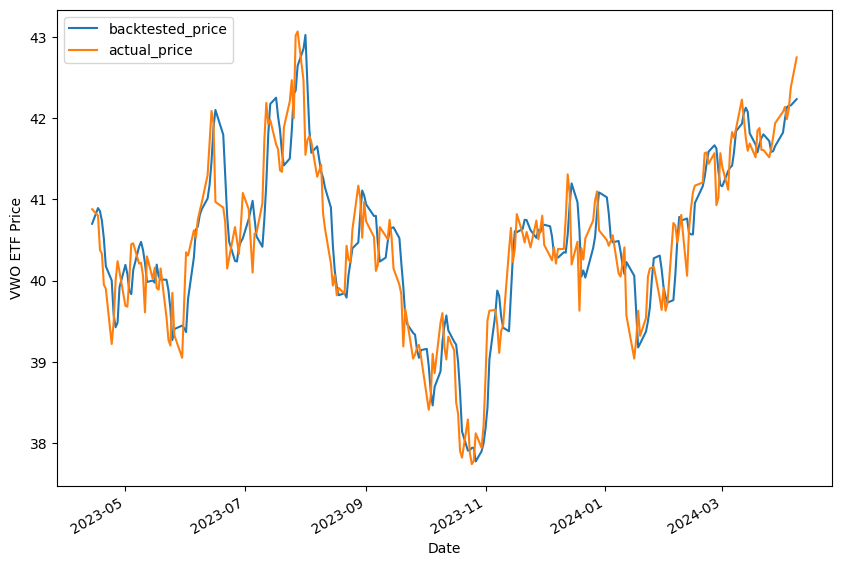

                price
Date                 
2023-04-14  40.700724
2023-04-17  40.893782
2023-04-18  40.855804
2023-04-19  40.737242
2023-04-20  40.515502
...               ...
2024-04-02  41.993460
2024-04-03  42.137737
2024-04-04  42.155334
2024-04-05  42.158084
2024-04-08  42.236052

[247 rows x 1 columns]


In [4]:
# backtest: predict VWO ETF price in test data
backtest_price = linear.predict(x_test)
backtest_price = pd.DataFrame(
    backtest_price, index=y_test.index, columns=['price'])
backtest_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['backtested_price', 'actual_price'])
plt.ylabel("VWO ETF Price")
plt.show()

print(backtest_price)
# export to excel
export_df = pd.DataFrame({
    'dates': x_test.index, 
    'actual_price': y_test,
    'backtested_price': backtest_price['price']  
})

# Export the DataFrame to an Excel file
export_df.to_excel('VWO_backtest_results.xlsx', index=False)

In [6]:
# predict next three months of results

# load original data
df = yf.download('VWO', '2019-05-01', '2024-04-10')
df = df[['Close']]
df = df.dropna()
df['S_3'] = df['Close'].rolling(window=3).mean()
df['S_9'] = df['Close'].rolling(window=9).mean()
df = df.dropna()

current_date = df.index[-1]
end_date = datetime(2024, 7, 31)

print("original df")
print(df)
while current_date <= end_date:
    # forecast the price
    df['predicted_price'] = linear.predict(df[['S_3', 'S_9']])
    last_row = df.tail(1)
    predicted_nlr_price = last_row['predicted_price'].iloc[-1]
    # print("predicted price: ", predicted_nlr_price)
    # print("after calculating predicted price")
    # print(df)

    last_date = df.index[-1]
    new_date = last_date + timedelta(days=1)
    current_date = new_date
    new_row = pd.DataFrame(index=[new_date], columns=df.columns)
    new_row['Close'] = predicted_nlr_price
    moving_avg_list = df['Close'].iloc[-8:].tolist()
    moving_avg_list.append(predicted_nlr_price)
    new_row['S_3'] = sum(moving_avg_list[-3:]) / 3
    new_row['S_9'] = sum(moving_avg_list) / 9
    warnings.filterwarnings("ignore", message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.*")
    df = pd.concat([df, new_row])   
    # print("after adding new row")
    # print(df)

# adjust to only weekly data 
df = df.resample('W-FRI').last() # only weekly data 
# export to excel
export_df = pd.DataFrame({
    'Dates': df.index, 
    'Historical Price': df['Close'], 
    'Base': df['predicted_price'],
})

# Export the DataFrame to an Excel file
export_df.to_excel('VWO_predicted_results.xlsx', index=False)

[*********************100%%**********************]  1 of 1 completed


original df
                Close        S_3        S_9
Date                                       
2019-05-13  40.279999  41.106665  42.262221
2019-05-14  40.840000  40.936666  42.003333
2019-05-15  40.950001  40.690000  41.750000
2019-05-16  40.849998  40.880000  41.423333
2019-05-17  40.070000  40.623333  41.113333
...               ...        ...        ...
2024-04-03  42.139999  42.053333  41.797778
2024-04-04  41.990002  42.070001  41.810001
2024-04-05  42.119999  42.083333  41.866667
2024-04-08  42.380001  42.163334  41.952223
2024-04-09  42.750000  42.416667  42.088889

[1236 rows x 3 columns]
